## POS tagging using modified Viterbi

### Data Preparation

In [339]:
#Importing libraries
import numpy as np
import pandas as pd
import nltk
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
from nltk.tokenize import word_tokenize

In [340]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [341]:
print(len(nltk_data))

3914


In [342]:
# splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data, test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:2])

3718
196
[[('Too', 'ADV'), ('much', 'ADJ'), ('money', 'NOUN'), ('*ICH*-1', 'X'), ('is', 'VERB'), ('at', 'ADP'), ('stake', 'NOUN'), ('for', 'ADP'), ('program', 'NOUN'), ('traders', 'NOUN'), ('to', 'PRT'), ('give', 'VERB'), ('up', 'ADP'), ('.', '.')], [('Also', 'ADV'), ('contributing', 'VERB'), ('to', 'PRT'), ('the', 'DET'), ('firmness', 'NOUN'), ('in', 'ADP'), ('copper', 'NOUN'), (',', '.'), ('the', 'DET'), ('analyst', 'NOUN'), ('noted', 'VERB'), ('0', 'X'), ('*T*-4', 'X'), (',', '.'), ('was', 'VERB'), ('*T*-3', 'X'), ('a', 'DET'), ('report', 'NOUN'), ('by', 'ADP'), ('Chicago', 'NOUN'), ('purchasing', 'VERB'), ('agents', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-1', 'X'), ('precedes', 'VERB'), ('the', 'DET'), ('full', 'ADJ'), ('purchasing', 'VERB'), ('agents', 'NOUN'), ("'", 'PRT'), ('report', 'NOUN'), ('that', 'DET'), ('*T*-2', 'X'), ('is', 'VERB'), ('due', 'ADJ'), ('out', 'ADP'), ('today', 'NOUN'), ('and', 'CONJ'), ('gives', 'VERB'), ('an', 'DET'), ('indication', 'NOUN'), ('of', 'A

In [343]:
tagged_words = [x for sent in train_set for x in sent]       

In [344]:
len(tagged_words)

95458

In [345]:
tagged_words

[('Too', 'ADV'),
 ('much', 'ADJ'),
 ('money', 'NOUN'),
 ('*ICH*-1', 'X'),
 ('is', 'VERB'),
 ('at', 'ADP'),
 ('stake', 'NOUN'),
 ('for', 'ADP'),
 ('program', 'NOUN'),
 ('traders', 'NOUN'),
 ('to', 'PRT'),
 ('give', 'VERB'),
 ('up', 'ADP'),
 ('.', '.'),
 ('Also', 'ADV'),
 ('contributing', 'VERB'),
 ('to', 'PRT'),
 ('the', 'DET'),
 ('firmness', 'NOUN'),
 ('in', 'ADP'),
 ('copper', 'NOUN'),
 (',', '.'),
 ('the', 'DET'),
 ('analyst', 'NOUN'),
 ('noted', 'VERB'),
 ('0', 'X'),
 ('*T*-4', 'X'),
 (',', '.'),
 ('was', 'VERB'),
 ('*T*-3', 'X'),
 ('a', 'DET'),
 ('report', 'NOUN'),
 ('by', 'ADP'),
 ('Chicago', 'NOUN'),
 ('purchasing', 'VERB'),
 ('agents', 'NOUN'),
 (',', '.'),
 ('which', 'DET'),
 ('*T*-1', 'X'),
 ('precedes', 'VERB'),
 ('the', 'DET'),
 ('full', 'ADJ'),
 ('purchasing', 'VERB'),
 ('agents', 'NOUN'),
 ("'", 'PRT'),
 ('report', 'NOUN'),
 ('that', 'DET'),
 ('*T*-2', 'X'),
 ('is', 'VERB'),
 ('due', 'ADJ'),
 ('out', 'ADP'),
 ('today', 'NOUN'),
 ('and', 'CONJ'),
 ('gives', 'VERB'),
 ('an',

In [346]:
#POS Taggers
tags = [pair[1] for pair in tagged_words]
unique_tags = set(tags)
len(unique_tags)
unique_tags

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [347]:
#Words
tokens = [pair[0] for pair in tagged_words]
unique_tokens = set(tokens)
unique_tokens

{'Guard',
 'considerably',
 '4.5',
 'Britain',
 '14.28',
 '0.9',
 'types',
 'third-highest',
 'healing',
 'offerings',
 'Norwalk',
 'skepticism',
 'slightly',
 'Rather',
 '*T*-258',
 'RATES',
 'exposure',
 'follow',
 'verge',
 'new',
 'Cheese',
 'convertible',
 '*T*-96',
 'auspices',
 'box',
 'Book',
 '230-215',
 'hotels',
 'response',
 'Angels',
 'inflation',
 'crowd',
 'academic',
 '100,980',
 'big',
 'consistently',
 'revolves',
 'goal',
 'amusing',
 'front',
 'mistrials',
 'powers',
 'Dell',
 'disclosed',
 'finance',
 'rights',
 'Philadelphia-based',
 'different',
 'retailer',
 'Arthur',
 'surveyed',
 'gilt',
 'sacrificing',
 'diming',
 'delisted',
 'fabricate',
 'replacing',
 'value',
 'schools',
 'assassinated',
 'senses',
 'plainclothes',
 'jet',
 'Plains',
 'Now',
 'cuts',
 'collective-bargaining',
 'clouds',
 'Albany',
 'profess',
 'documents',
 'accusing',
 'partner',
 'abandoned',
 'suburban',
 'Rico',
 'enters',
 'Turkey',
 'ON',
 'eight-month',
 'shirt-sleeved',
 'refuses'

In [348]:
len(unique_tokens)

12123

### Build the vanilla Viterbi based POS tagger

In [349]:
# computing P(w/t) and storing in T x V matrix
t = len(unique_tags)
v = len(unique_tokens)
w_given_t = np.zeros((t, v))

In [350]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [351]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [352]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(unique_tags), len(unique_tags)), dtype='float32')
for i, t1 in enumerate(list(unique_tags)):
    for j, t2 in enumerate(list(unique_tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [353]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(unique_tags), index=list(unique_tags))

In [354]:
tags_df

,ADV,CONJ,NUM,PRON,ADJ,.,NOUN,VERB,X,ADP,PRT,DET
ADV,0.080159,0.006625,0.031136,0.015237,0.129513,0.136469,0.032130,0.344485,0.023186,0.118914,0.014243,0.067903
CONJ,0.053704,0.000463,0.042130,0.058333,0.117593,0.035648,0.350926,0.158796,0.007870,0.050463,0.004630,0.119444
NUM,0.002962,0.013033,0.186315,0.001481,0.032879,0.114633,0.353081,0.017476,0.212382,0.035545,0.026955,0.003258
PRON,0.034911,0.005043,0.007758,0.007370,0.072537,0.040341,0.208689,0.486424,0.091544,0.023274,0.012801,0.009310
ADJ,0.004947,0.017150,0.020449,0.000660,0.066128,0.065303,0.698879,0.012368,0.020778,0.077672,0.010719,0.004947
.,0.052874,0.059009,0.081657,0.065416,0.044573,0.092123,0.221240,0.088153,0.027610,0.090770,0.002346,0.174141
NOUN,0.017138,0.042936,0.009135,0.004750,0.012461,0.239823,0.263977,0.146313,0.029306,0.176716,0.043996,0.013447
VERB,0.081931,0.005374,0.023209,0.035358,0.064642,0.034969,0.110202,0.168224,0.216667,0.091900,0.031620,0.135903
X,0.025968,0.010037,0.002868,0.054803,0.017206,0.163613,0.061494,0.206309,0.074717,0.143381,0.185120,0.054485
ADP,0.013396,0.000750,0.063337,0.068589,0.105026,0.039117,0.323652,0.008359,0.034723,0.016504,0.001500,0.325046


In [355]:
tags_df.loc['.', :]

ADV     0.052874
CONJ    0.059009
NUM     0.081657
PRON    0.065416
ADJ     0.044573
.       0.092123
NOUN    0.221240
VERB    0.088153
X       0.027610
ADP     0.090770
PRT     0.002346
DET     0.174141
Name: ., dtype: float32

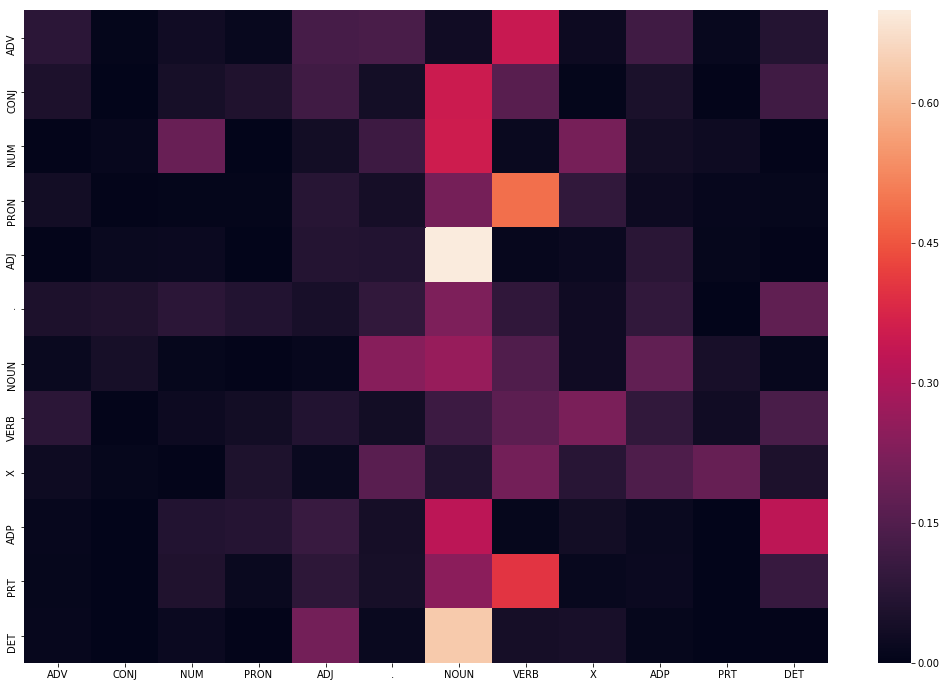

In [356]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

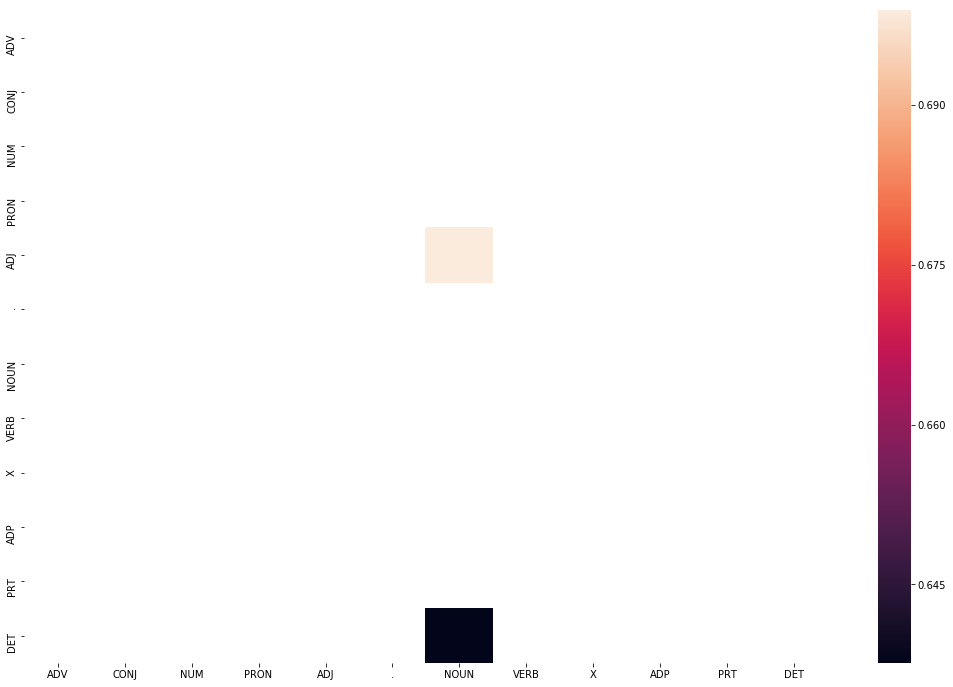

In [357]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [358]:
# Viterbi Heuristic
def Viterbi(words, train_bag = tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


In [359]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('We', 'PRON'),
  ('-LRB-', '.'),
  ('I', 'PRON'),
  ('assume', 'VERB'),
  ('0', 'X'),
  ('you', 'PRON'),
  ("'re", 'VERB'),
  ('in', 'ADP'),
  ('this', 'DET'),
  ('with', 'ADP'),
  ('me', 'PRON'),
  ('at', 'ADP'),
  ('this', 'DET'),
  ('point', 'NOUN'),
  ('-RRB-', '.'),
  ('need', 'VERB'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('get', 'VERB'),
  ('three', 'NUM'),
  ('words', 'NOUN'),
  ('--', '.'),
  ('``', '.'),
  ('for', 'ADP'),
  ('examination', 'NOUN'),
  ('only', 'ADV'),
  ("''", '.'),
  ('--', '.'),
  ('eliminated', 'VERB'),
  ('from', 'ADP'),
  ('the', 'DET'),
  ('law', 'NOUN'),
  ('.', '.')],
 [('``', '.'),
  ('There', 'DET'),
  ('were', 'VERB'),
  ('so', 'ADV'),
  ('many', 'ADJ'),
  ('economic', 'ADJ'),
  ('reports', 'NOUN'),
  ('but', 'CONJ'),
  ('the', 'DET'),
  ('market', 'NOUN'),
  ('did', 'VERB'),
  ("n't", 'ADV'),
  ('care', 'VERB'),
  ('about', 'ADP'),
  ('any', 'DET'),
  ('of', 'ADP'),
  ('them', 'PRON'),
  (',', '.'),
  ("''", '.'),
  ('said', 'VERB'),
  ('*T*-1', 'X

In [360]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [361]:
print("Time taken in seconds: ", difference)
print(tagged_seq)


Time taken in seconds:  26.739134073257446
[('We', 'PRON'), ('-LRB-', '.'), ('I', 'PRON'), ('assume', 'VERB'), ('0', 'X'), ('you', 'PRON'), ("'re", 'VERB'), ('in', 'ADP'), ('this', 'DET'), ('with', 'ADP'), ('me', 'PRON'), ('at', 'ADP'), ('this', 'DET'), ('point', 'NOUN'), ('-RRB-', '.'), ('need', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('get', 'VERB'), ('three', 'NUM'), ('words', 'NOUN'), ('--', '.'), ('``', '.'), ('for', 'ADP'), ('examination', 'NOUN'), ('only', 'ADV'), ("''", '.'), ('--', '.'), ('eliminated', 'VERB'), ('from', 'ADP'), ('the', 'DET'), ('law', 'NOUN'), ('.', '.'), ('``', '.'), ('There', 'DET'), ('were', 'VERB'), ('so', 'ADV'), ('many', 'ADJ'), ('economic', 'ADJ'), ('reports', 'NOUN'), ('but', 'CONJ'), ('the', 'DET'), ('market', 'NOUN'), ('did', 'VERB'), ("n't", 'ADV'), ('care', 'VERB'), ('about', 'ADP'), ('any', 'DET'), ('of', 'ADP'), ('them', 'PRON'), (',', '.'), ("''", '.'), ('said', 'VERB'), ('*T*-1', 'X'), ('Kathleen', 'ADV'), ('Camilli', 'ADV'), (',', '.'), ('a', 'D

In [362]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [363]:
accuracy = len(check)/len(tagged_seq)

In [364]:
accuracy

0.9545454545454546

In [365]:
#incorrect tagged cases
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [366]:
incorrect_tagged_cases

[[('*T*-1', 'X'), (('Kathleen', 'ADV'), ('Kathleen', 'NOUN'))],
 [('Kathleen', 'NOUN'), (('Camilli', 'ADV'), ('Camilli', 'NOUN'))],
 [('*ICH*-1', 'X'), (('Takeshi', 'ADV'), ('Takeshi', 'NOUN'))],
 [('Takeshi', 'NOUN'), (('Kondo', 'ADV'), ('Kondo', 'NOUN'))],
 [('$', '.'), (('576', 'ADV'), ('576', 'NUM'))],
 [('already', 'ADV'), (('own', 'ADJ'), ('own', 'VERB'))],
 [('his', 'PRON'), (('return', 'VERB'), ('return', 'NOUN'))]]

In [367]:
# Testing on Test_sentences.txt Data
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
vannila_test_tagged_seq = tagged_seq

[('Android', 'ADV'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADV'), ('.', '.'), ('Android', 'ADV'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADV'), ('worldwide', 'ADV'), ('on', 'ADP'), ('smartphones', 'ADV'), ('since', 'ADP'), ('2011', 'ADV'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADV'), ('.', '.'), ('Google', 'ADV'), ('and', 'CONJ'), ('Twitter', 'ADV'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADV'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADV'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADV'), ("'s", 'PRT'), ('firehose', 'ADV'), ('.', '.'), ('Twitter', 'ADV'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADV'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOU

### Solve the problem of unknown words

In [368]:
# specify patterns for tagging
# example from the NLTK book
patterns = [
        (r'[-+]?\d*\.\d+|\d+', 'NUM'), # Number with floating values
        (r'.*es$', 'VERB'), 
        (r'.*ing$', 'VERB'), # gerunds or continuous tense
        (r'.*ed$', 'VERB'),  # past perfect tense
        (r'[A-Z ]+', 'NOUN'),  # all caps eg. FIFA, NASA, etc
        (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
        (r'.*', 'NOUN'), # default value as NOUN
]

In [369]:
regexp_tagger = nltk.RegexpTagger(patterns)
regexp_tagger.evaluate(test_set)

0.33116136450747413

In [370]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger.evaluate(test_set)

0.9143349942506708

In [371]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)
lexicon_tagger.evaluate(test_set)

0.9505557684936757

In [372]:
def rule_based_tagging(word, pattern):
    regexp_tagger = nltk.RegexpTagger(pattern)
    kv = regexp_tagger.tag(nltk.word_tokenize(word))
    for v in kv:
        print(word)
        print(v[1])
        return v[1]

In [373]:
# Viterbi Heuristic using Rule Based Tagging.
def modified_Viterbi_rule_based(words, train_bag = tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, patterns)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_rule_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)

Kathleen
NOUN
Camilli
NOUN
Takeshi
NOUN
Kondo
NOUN
576
NUM
Time taken in seconds:  27.203584909439087
[('We', 'PRON'), ('-LRB-', '.'), ('I', 'PRON'), ('assume', 'VERB'), ('0', 'X'), ('you', 'PRON'), ("'re", 'VERB'), ('in', 'ADP'), ('this', 'DET'), ('with', 'ADP'), ('me', 'PRON'), ('at', 'ADP'), ('this', 'DET'), ('point', 'NOUN'), ('-RRB-', '.'), ('need', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('get', 'VERB'), ('three', 'NUM'), ('words', 'NOUN'), ('--', '.'), ('``', '.'), ('for', 'ADP'), ('examination', 'NOUN'), ('only', 'ADV'), ("''", '.'), ('--', '.'), ('eliminated', 'VERB'), ('from', 'ADP'), ('the', 'DET'), ('law', 'NOUN'), ('.', '.'), ('``', '.'), ('There', 'DET'), ('were', 'VERB'), ('so', 'ADV'), ('many', 'ADJ'), ('economic', 'ADJ'), ('reports', 'NOUN'), ('but', 'CONJ'), ('the', 'DET'), ('market', 'NOUN'), ('did', 'VERB'), ("n't", 'ADV'), ('care', 'VERB'), ('about', 'ADP'), ('any', 'DET'), ('of', 'ADP'), ('them', 'PRON'), (',', '.'), ("''", '.'), ('said', 'VERB'), ('*T*-1', 'X'), ('

In [374]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
rulebased_modified_viterbi_accuracy = len(check)/len(tagged_seq)
print(rulebased_modified_viterbi_accuracy)

0.987012987012987


In [375]:
#Incorrect tagged cases from modified_Viterbi_rule_based Model
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('already', 'ADV'), (('own', 'ADJ'), ('own', 'VERB'))],
 [('his', 'PRON'), (('return', 'VERB'), ('return', 'NOUN'))]]

In [376]:
# Testing on Test_sentences.txt Data using modified_Viterbi_rule_based Model
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_rule_based(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
rulebased_test_tagged_seq = tagged_seq

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NUM
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made

In [377]:

###Version 2 : Rule Based Tagging with Viterbi

def bigram_tagger(wording) :
    t0 = DefaultTagger('NOUN')
    t1 = UnigramTagger(train_set, backoff=t0)
    t2 = BigramTagger(train_set, backoff=t1)
    listvalue=t2.tag(nltk.word_tokenize(wording))
    return listvalue[0][1]

In [378]:

# Viterbi Heuristic using Lexicon Based Tagging
def modified_Viterbi_lexicon_based(words, train_bag = tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, patterns)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_lexicon_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)

Kathleen
NOUN
Camilli
NOUN
Takeshi
NOUN
Kondo
NOUN
576
NUM
Time taken in seconds:  28.793617963790894
[('We', 'PRON'), ('-LRB-', '.'), ('I', 'PRON'), ('assume', 'VERB'), ('0', 'X'), ('you', 'PRON'), ("'re", 'VERB'), ('in', 'ADP'), ('this', 'DET'), ('with', 'ADP'), ('me', 'PRON'), ('at', 'ADP'), ('this', 'DET'), ('point', 'NOUN'), ('-RRB-', '.'), ('need', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('get', 'VERB'), ('three', 'NUM'), ('words', 'NOUN'), ('--', '.'), ('``', '.'), ('for', 'ADP'), ('examination', 'NOUN'), ('only', 'ADV'), ("''", '.'), ('--', '.'), ('eliminated', 'VERB'), ('from', 'ADP'), ('the', 'DET'), ('law', 'NOUN'), ('.', '.'), ('``', '.'), ('There', 'DET'), ('were', 'VERB'), ('so', 'ADV'), ('many', 'ADJ'), ('economic', 'ADJ'), ('reports', 'NOUN'), ('but', 'CONJ'), ('the', 'DET'), ('market', 'NOUN'), ('did', 'VERB'), ("n't", 'ADV'), ('care', 'VERB'), ('about', 'ADP'), ('any', 'DET'), ('of', 'ADP'), ('them', 'PRON'), (',', '.'), ("''", '.'), ('said', 'VERB'), ('*T*-1', 'X'), ('

In [379]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
lexicon_based_viterbi_accuracy = len(check)/len(tagged_seq)
print(lexicon_based_viterbi_accuracy)

#Incorrect tagged cases from modified_Viterbi_lexicon_based Model
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases


0.987012987012987


[[('already', 'ADV'), (('own', 'ADJ'), ('own', 'VERB'))],
 [('his', 'PRON'), (('return', 'VERB'), ('return', 'NOUN'))]]

In [380]:
# Testing on Test_sentences.txt Data using modified_Viterbi_lexicon_based Model
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_lexicon_based(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
lexicon_test_tagged_seq = tagged_seq

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NUM
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made

#### Evaluating tagging accuracy

In [381]:
print("Vannila Viterbi Accuracy: "+ str(accuracy))
print("Lexicon Based Viterbi Accuracy: "+ str(lexicon_based_viterbi_accuracy))
print("Rule Based Viterbi Accuracy: "+ str(rulebased_modified_viterbi_accuracy))

Vannila Viterbi Accuracy: 0.9545454545454546
Lexicon Based Viterbi Accuracy: 0.987012987012987
Rule Based Viterbi Accuracy: 0.987012987012987


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

Lexicon Based Viterbi & Rule Based Viterbi's accuracy are greater than Plain Vannila Viterbi's accuracy.

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

1.In vanilla Viterbi Words like 'Twitter', 'Android', 'Google' was coming as ADjectives but in modified Viterbi Algorithm mentioned words are  properly tagged with 'NOUN'.

2.Words like 'NASA', 'FIFA' are correctly tagged as 'NOUN' (All Caps of a word generally will be an abbrevation and it is a noun).

3.Words ending with '-ing' like 'arriving' and words ending with '-ed' like 'invited' are properly tagged as 'VERB' in Rule Based Tagging.

4.Words with integers or float are properly tagged as 'NUM' are properly tagged as NUM in rule based tagger.

5.In Lexicon tagger, words are tagged as 'NOUN' by default in the default tagger if any of the taggers cannot able to tag them.

6.Basically it corrects most of the unknown words like 'Google', 'Android', 'Twitter' etc.